In [11]:
## --- Fast Import Snippet ---##
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import math, random
import pathlib
import time
import warnings
import itertools
import inspect
import numbers, string
import collections
from collections import namedtuple, OrderedDict
from pprint import pprint
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
import torchvision.transforms as T
import albumentations as A
from skimage.transform import resize as nd_resize
from scipy.ndimage import rotate as nd_rotate

np.set_printoptions(precision=3)
curr_path = pathlib.Path(os.getcwd()).parent.absolute()

cards = !echo $SGE_HGR_gpu_card
device = torch.device(f"cuda:{cards[0]}" if torch.cuda.is_available() else 'cpu')
print(device)

def plot_image(images, gray=True):
    assert gray
    
    if not isinstance(images, (tuple, list)):
        images = [images]
    
    plot_images = []
    for image in images:
        if image.ndim == 3:
            image = image[image.shape[0]//2, :, :]
        plot_images.append(image)
    
    fig = plt.figure(figsize=(8 * len(plot_images), 10))
    for i, image in enumerate(plot_images):
        ax = fig.add_subplot(1, len(plot_images), i + 1)
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Min, Max: {image.min():.2f} {image.max():.2f}')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:2


In [17]:
# Load Config
from run import get_experiment_cfg
config = get_experiment_cfg('prevec_general.yaml')

# Get Data Components
from experiments.prevec.data_setup import get_pretrain_data_components
data_d = get_pretrain_data_components(config)

[CFG] Given cfg file "prevec_general.yaml" does not exist! Searching for matching name in experiment's config folder..
 ✔ Cfg experiment matched at /afs/crc.nd.edu/user/y/yzhang46/_3DPRE/src/experiments/prevec/configs.
 > Loading config (prevec_general.yaml).. done.
🖼️  Getting MMWHS, BCV, MSD Liver, MSD Lung samples.
[Took 0.29 sec for 231 samples.]
🖼️  Task: mg, Config: {'test': False, 'num_classes': 1, 'prediction_head': False, 'prediction_head_dims': 128, 't_mg_flip': 0.4, 't_mg_shuffle': 0.5, 't_mg_shuffle_times': 10000, 't_mg_nonlinear': 0.9, 't_mg_paint': 0.9, 't_mg_inpaint': 0.3, 't_mg_inpaint_uniform': True, 't_mg_inpaint_times': 10, 't_mg_outpaint_uniform': True, 't_mg_outpaint_times': 10}.

Train Data Components:
🖼️  Sampling from scales: [0.75, 1.25]
💠 MGDataset created with 231 samples. 
   Crops/Vol=6, Virtual-Size=231.


In [18]:
loader = data_d['train_loader']
start = time.time()
for it, batch in enumerate(loader):
    samples = batch['samples']
    X = batch['X']
    Y = batch['Y']
    
    boundaries = batch['boundaries']
    boundary_masks = batch['boundary_masks']
    
    break
    

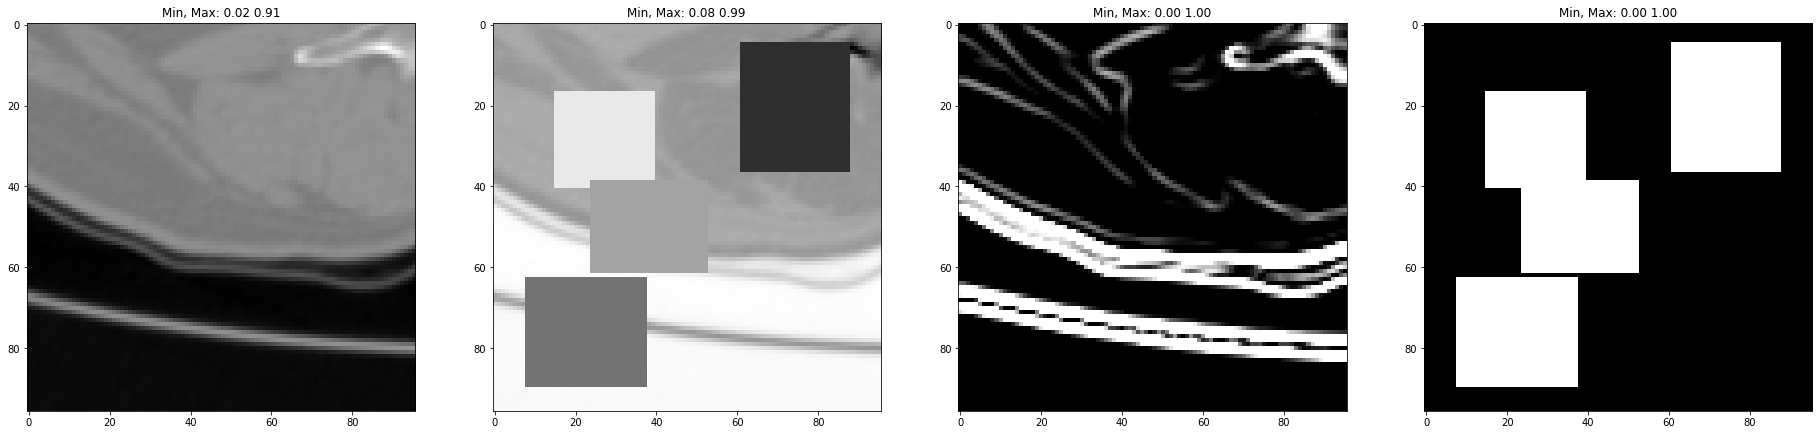

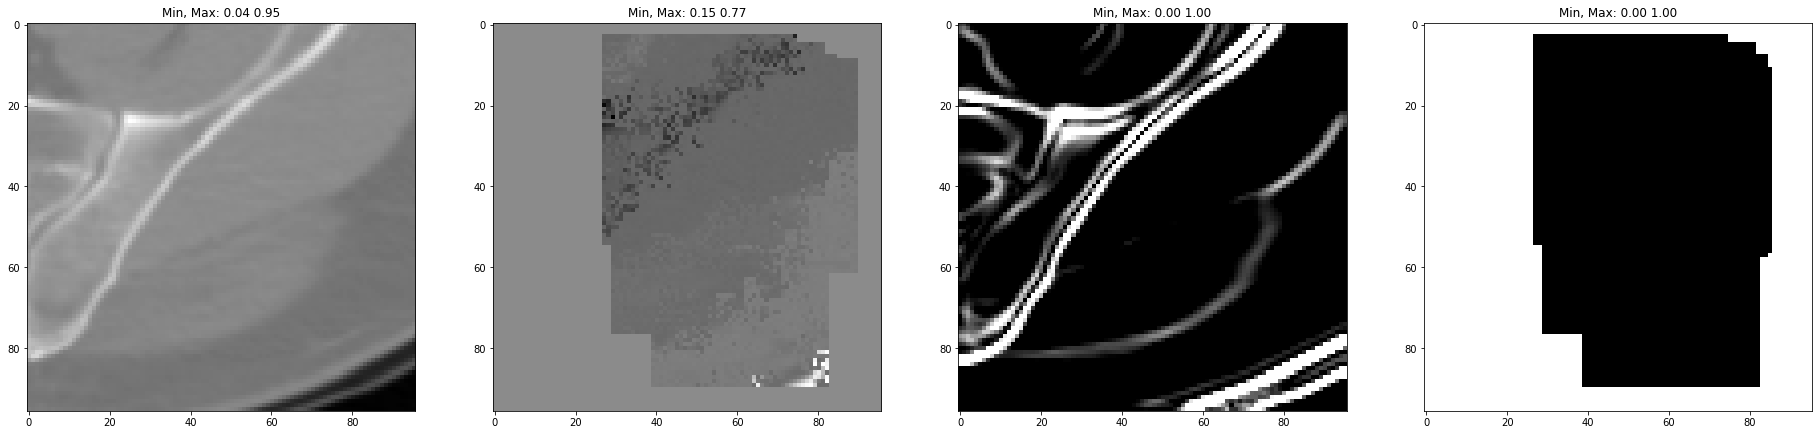

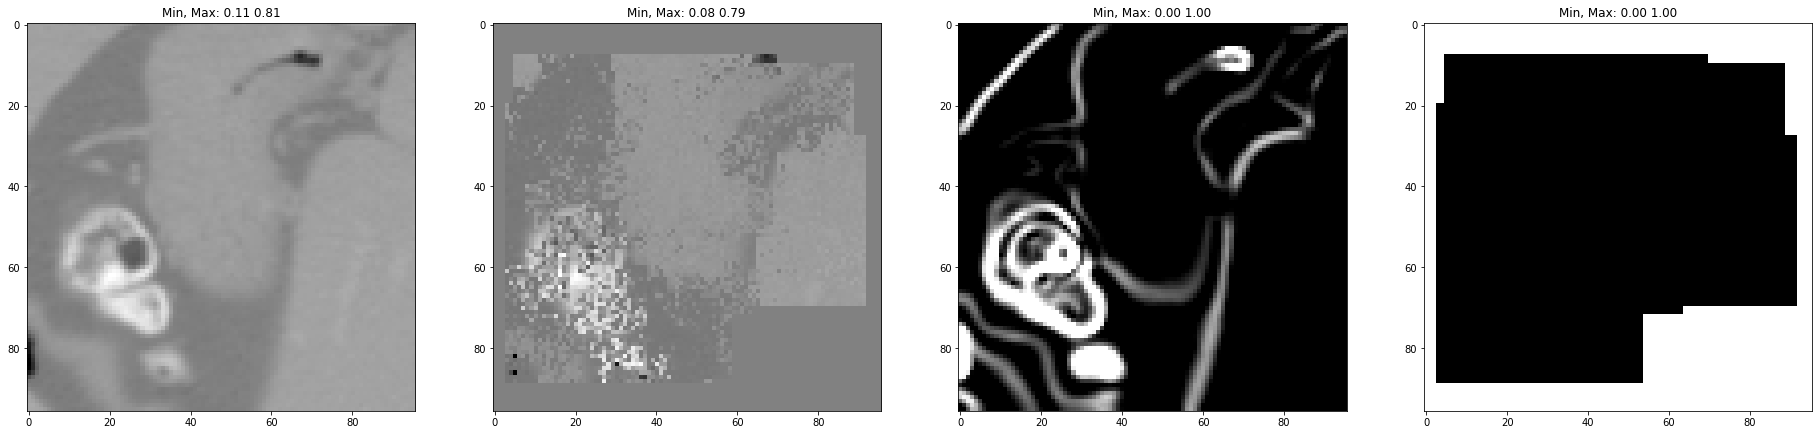

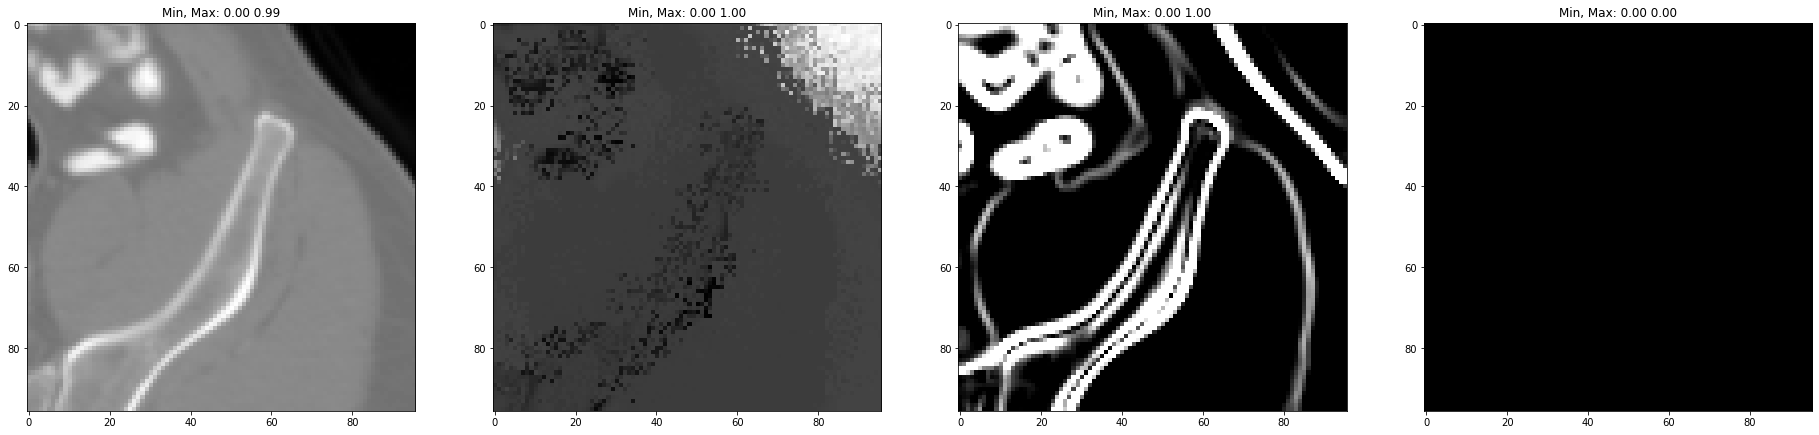

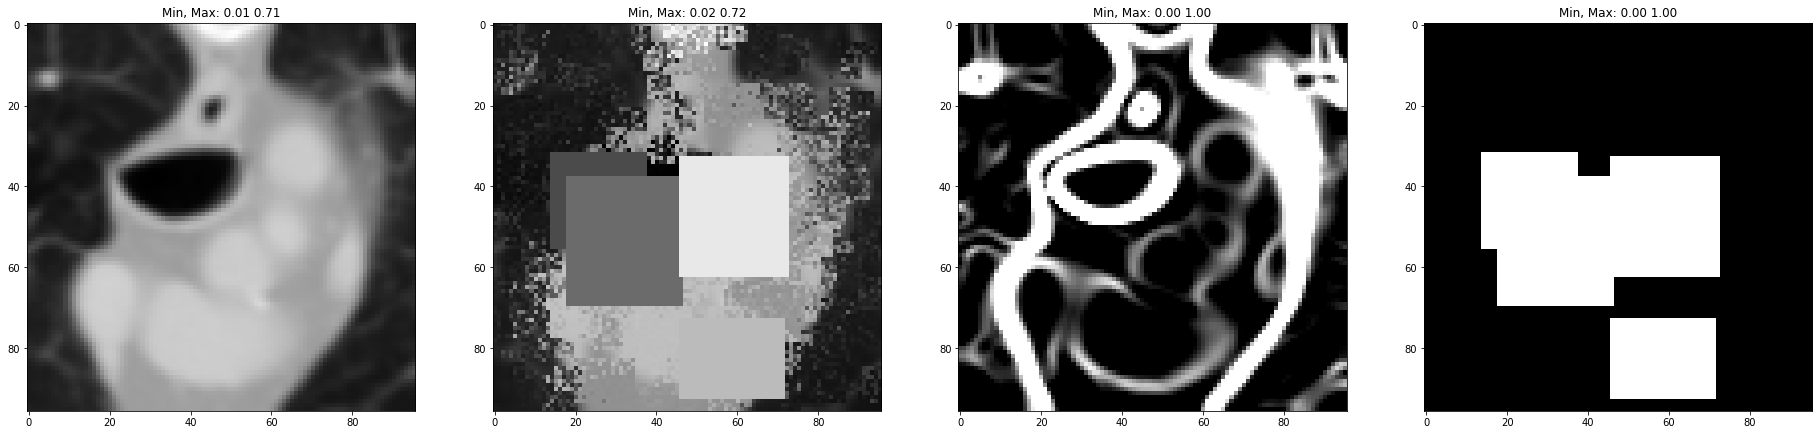

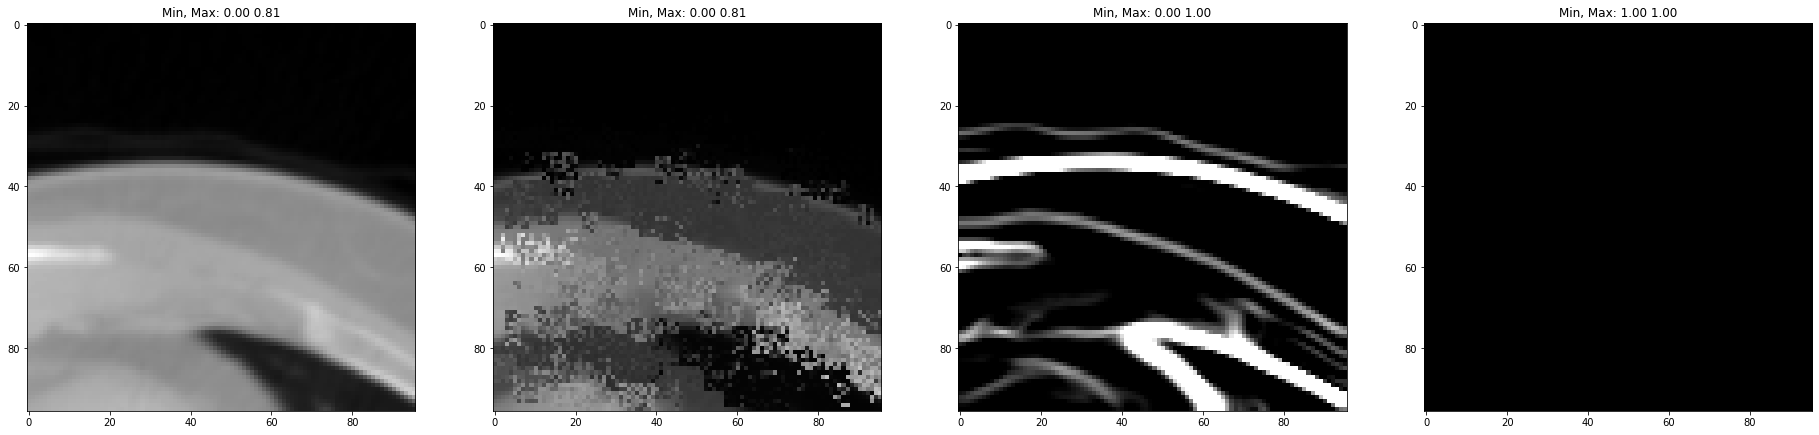

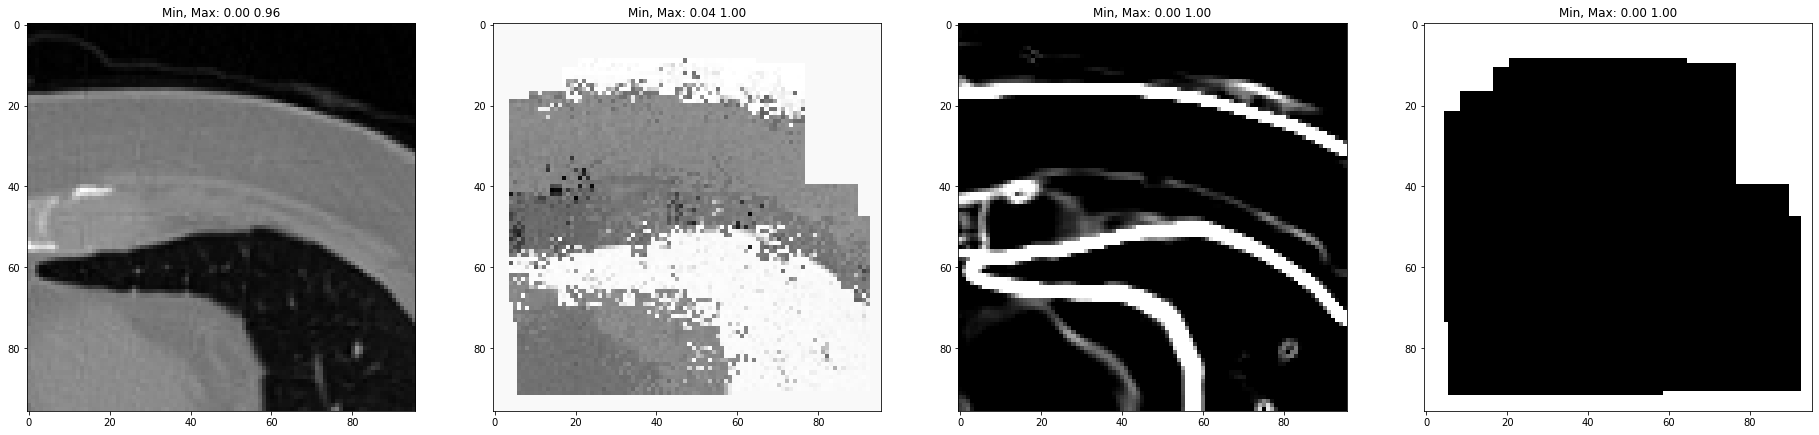

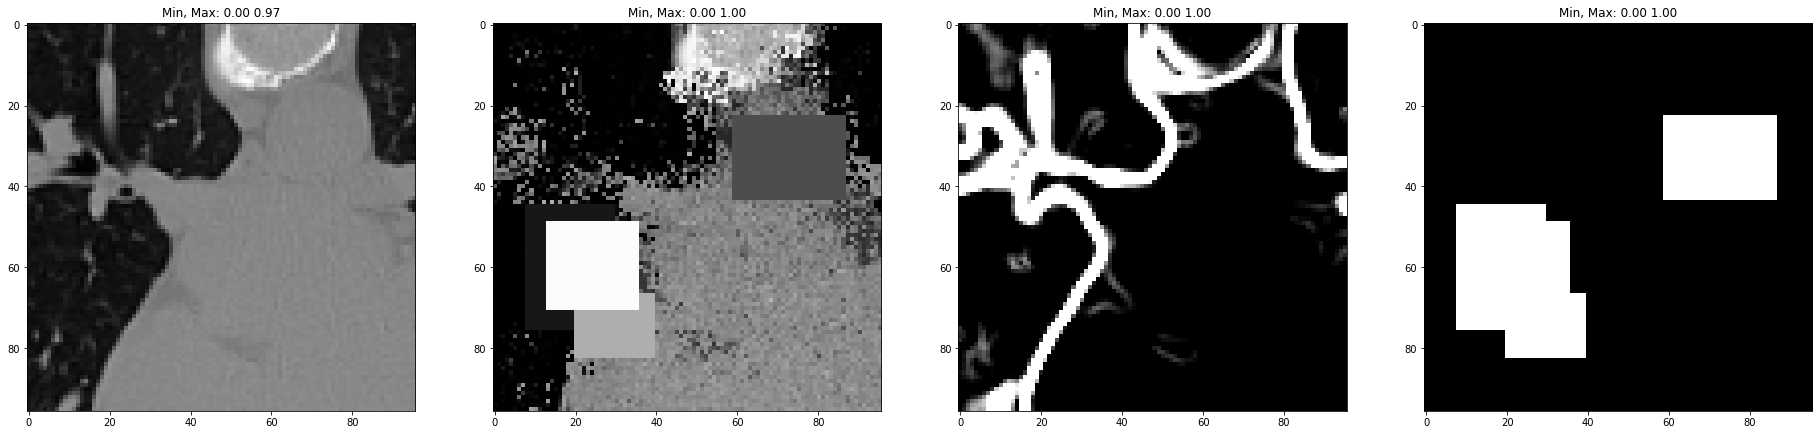

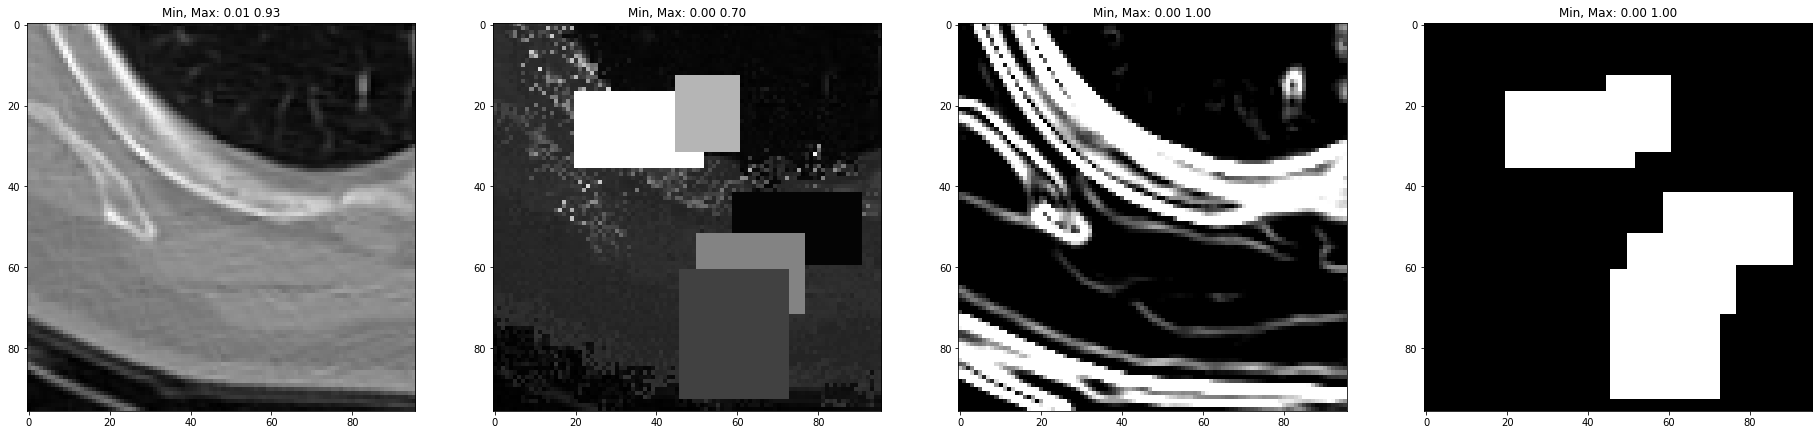

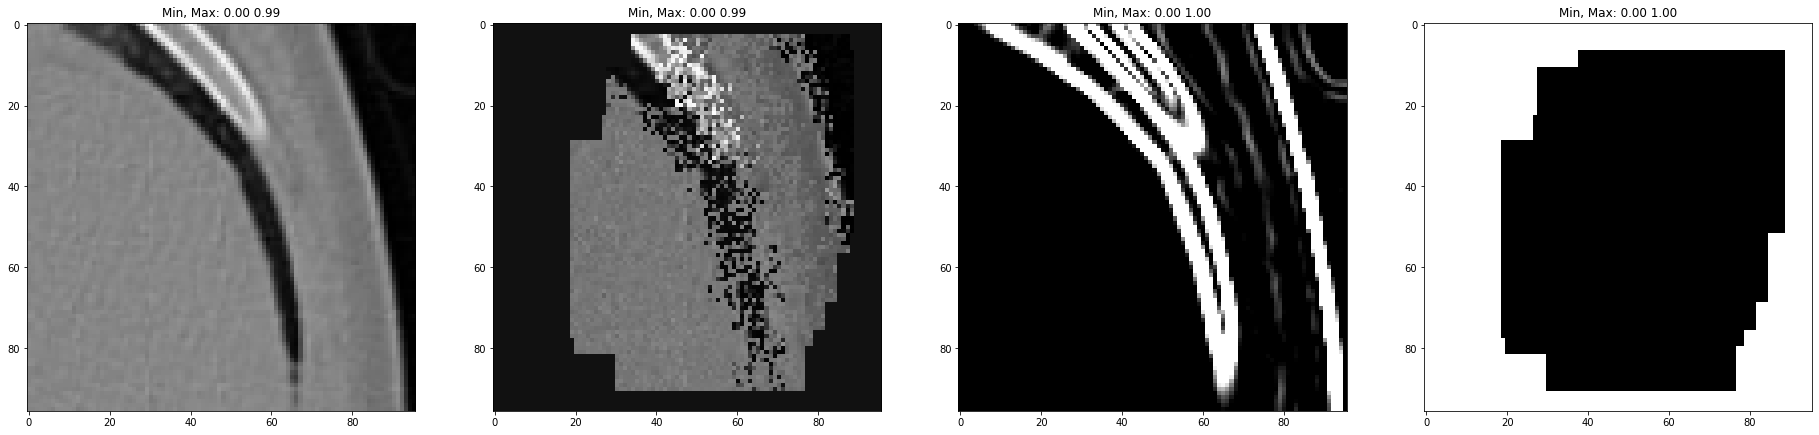

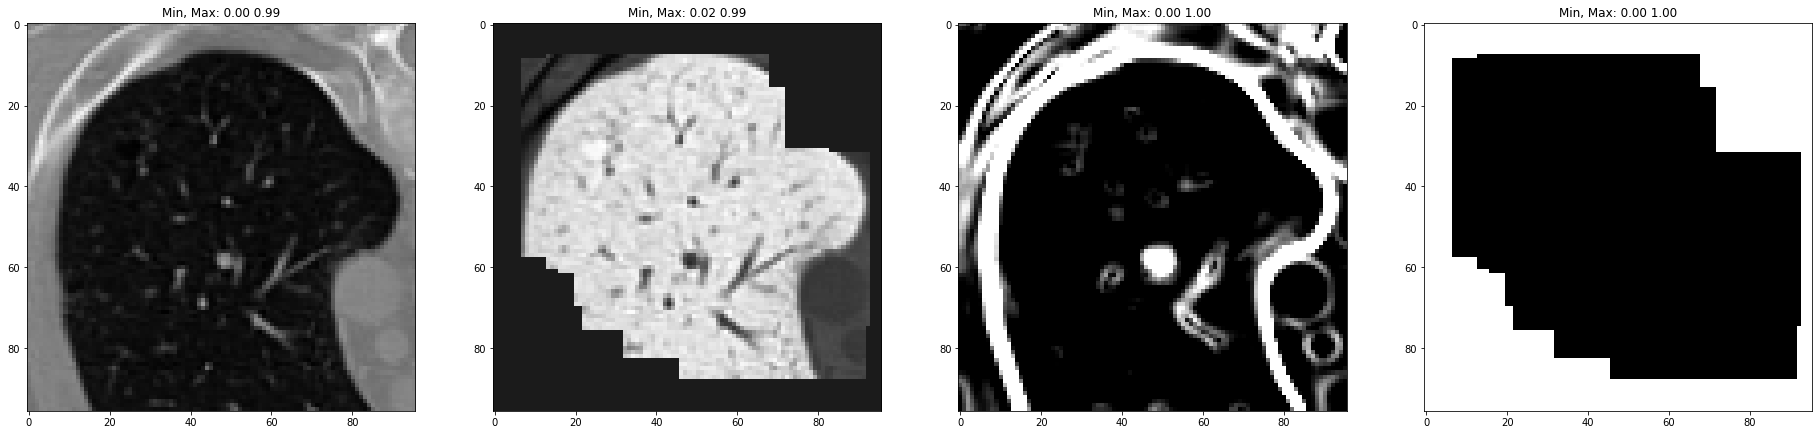

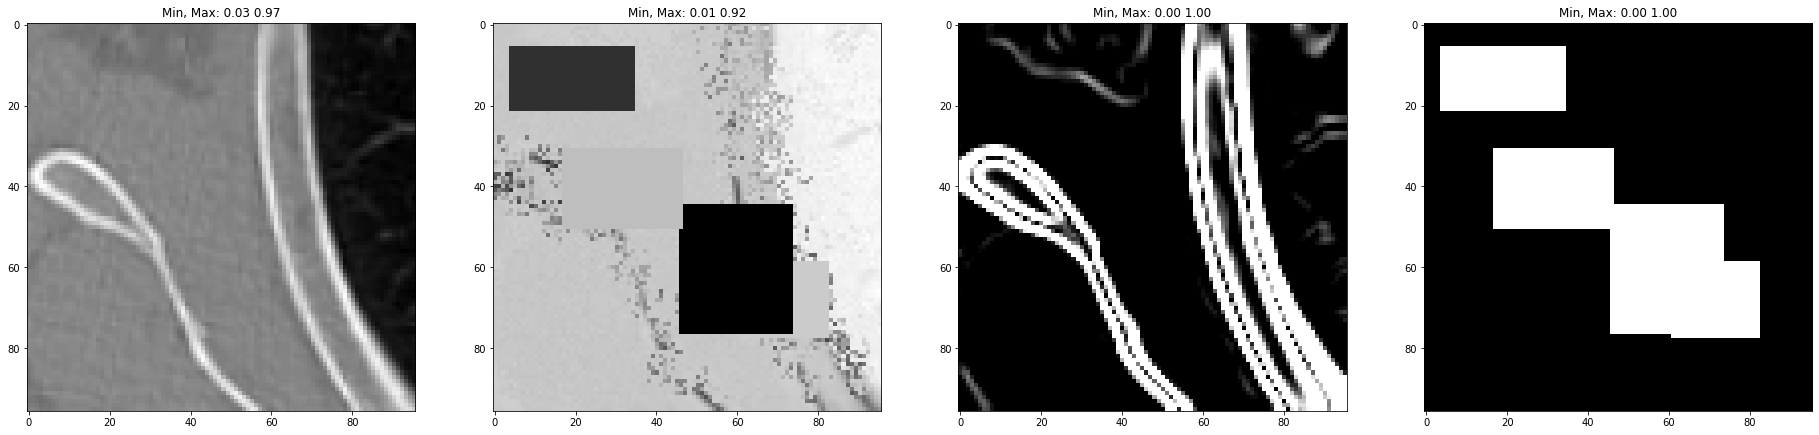

In [19]:
for b in range(Y.shape[0]):
    input_arr = X[b][0].numpy()
    image_arr = Y[b][0].numpy()
    boundary_arr = boundaries[b][0].numpy()
    boundary_mask_arr = boundary_masks[b][0].numpy()
    

    plot_image([image_arr, input_arr, boundary_arr, boundary_mask_arr])

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
from skimage.filters import threshold_otsu, rank

image_tens = Y[2][0]
image_arr = image_tens.numpy()
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image_tens[image_tens.shape[0]//2, :, :], cmap='gray')
plt.show()

NameError: name 'Y' is not defined

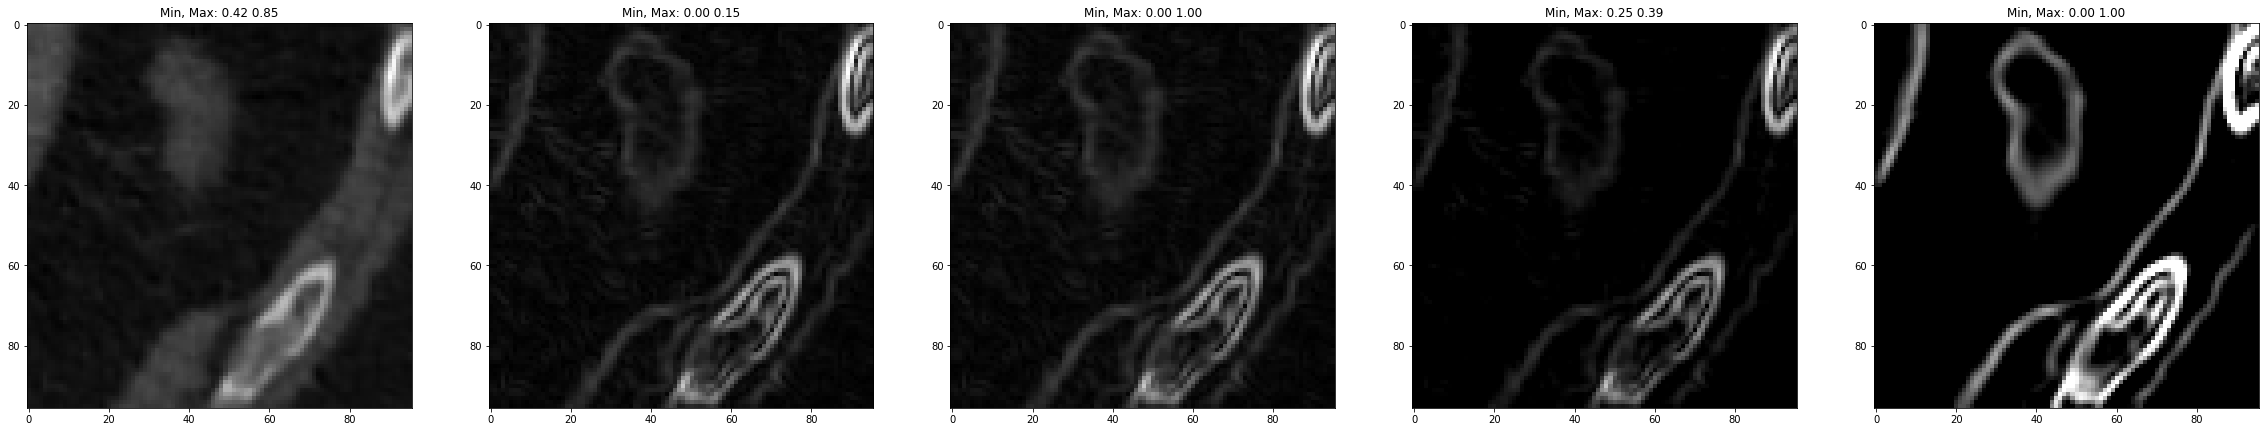

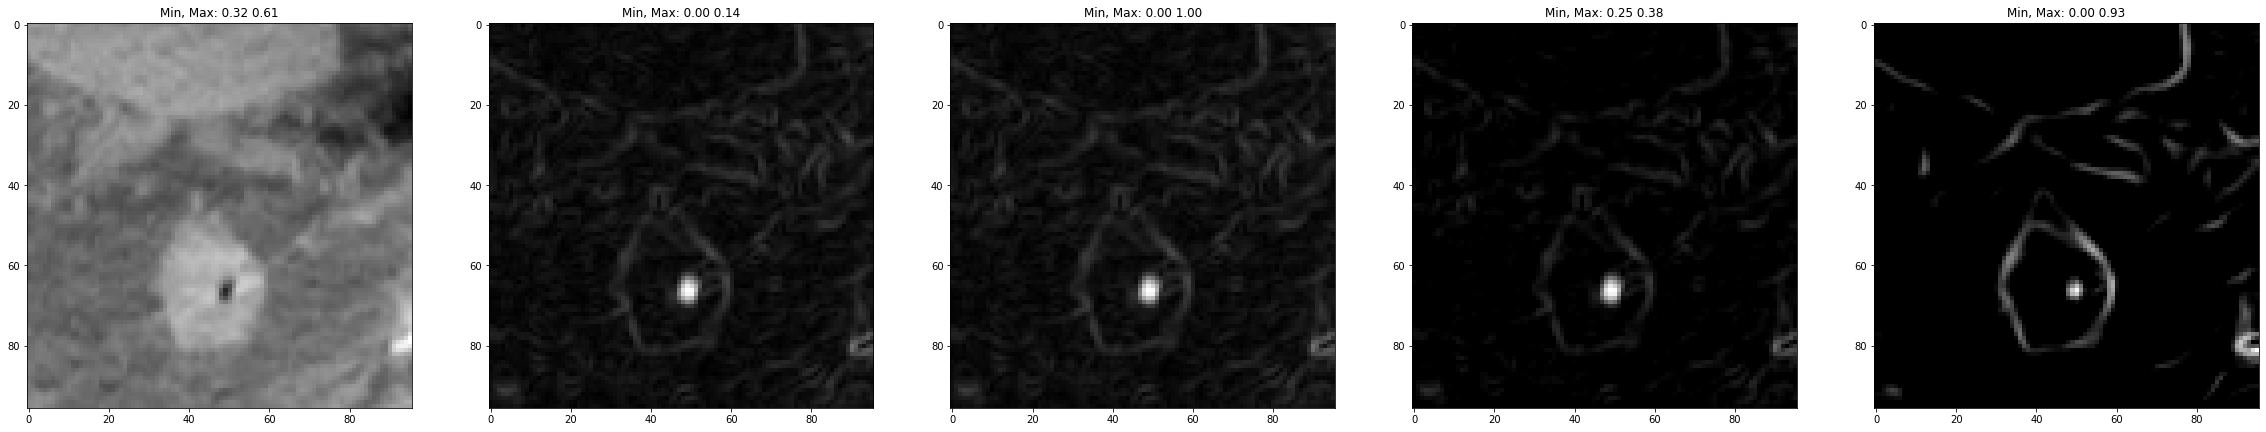

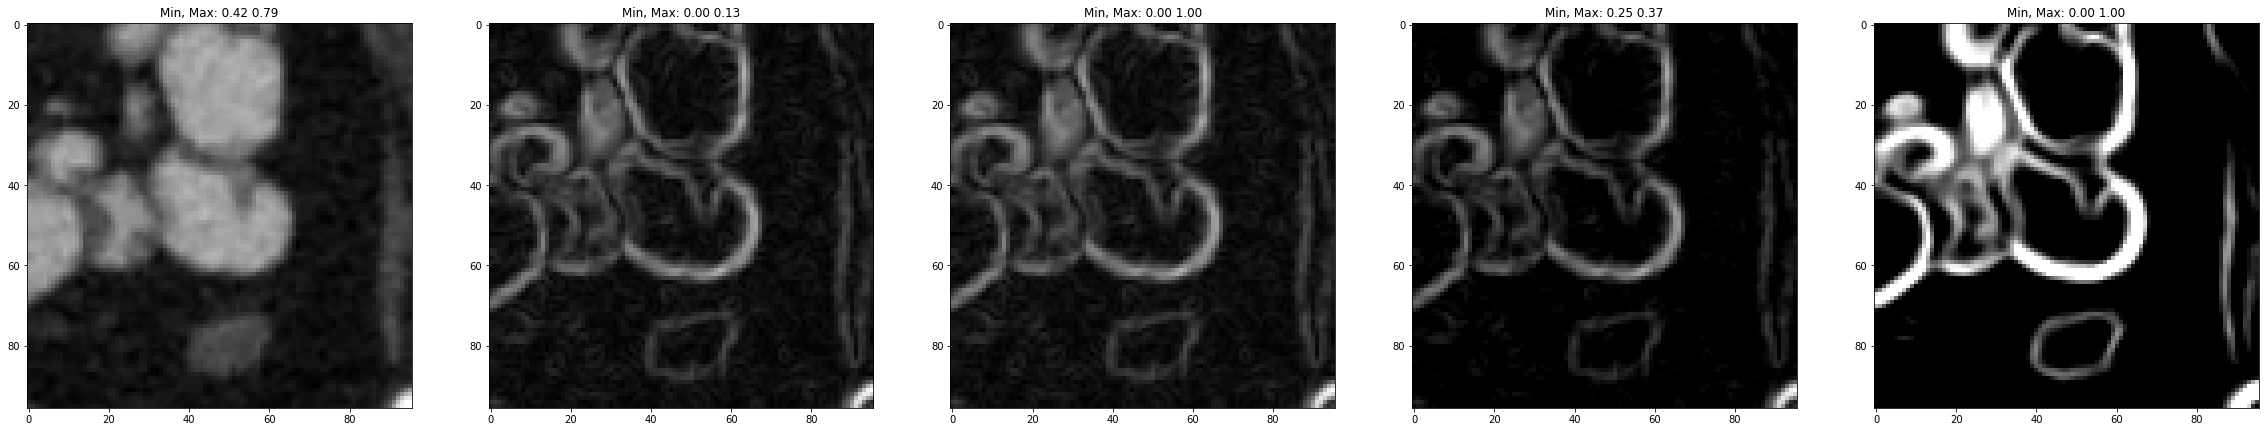

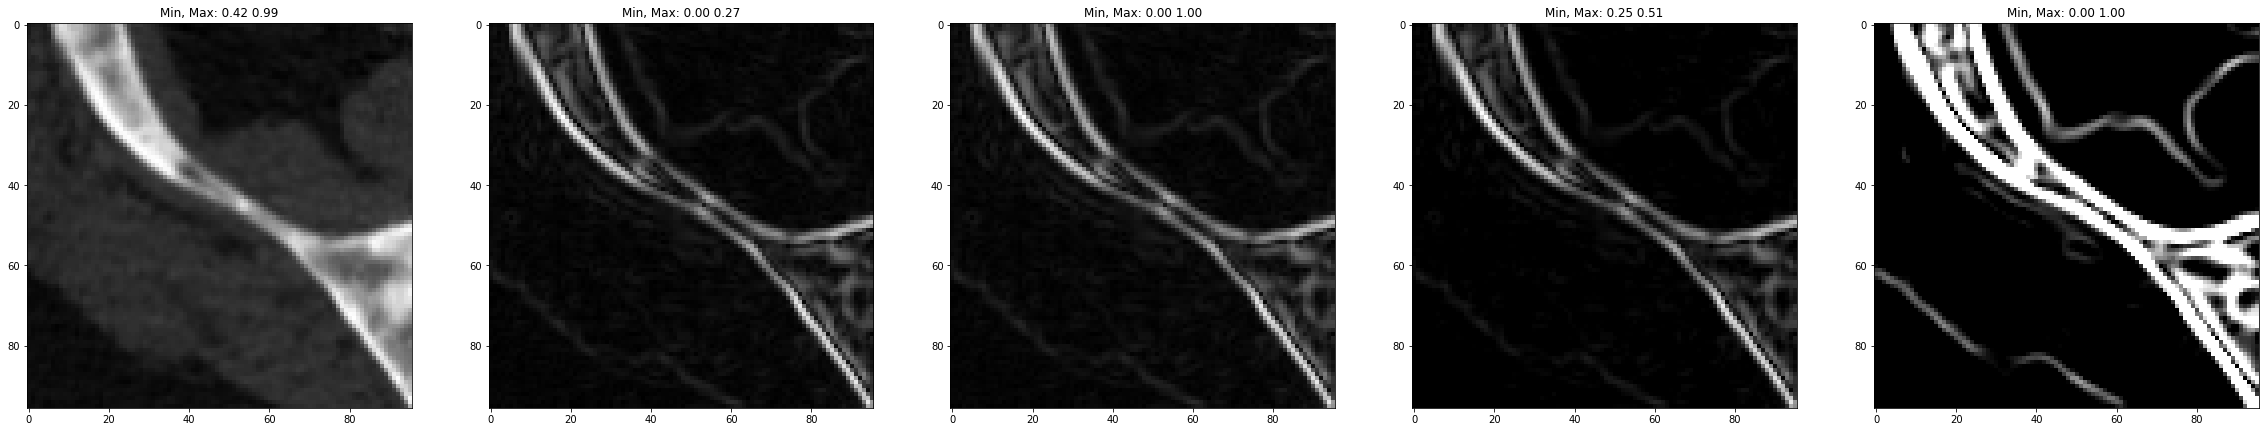

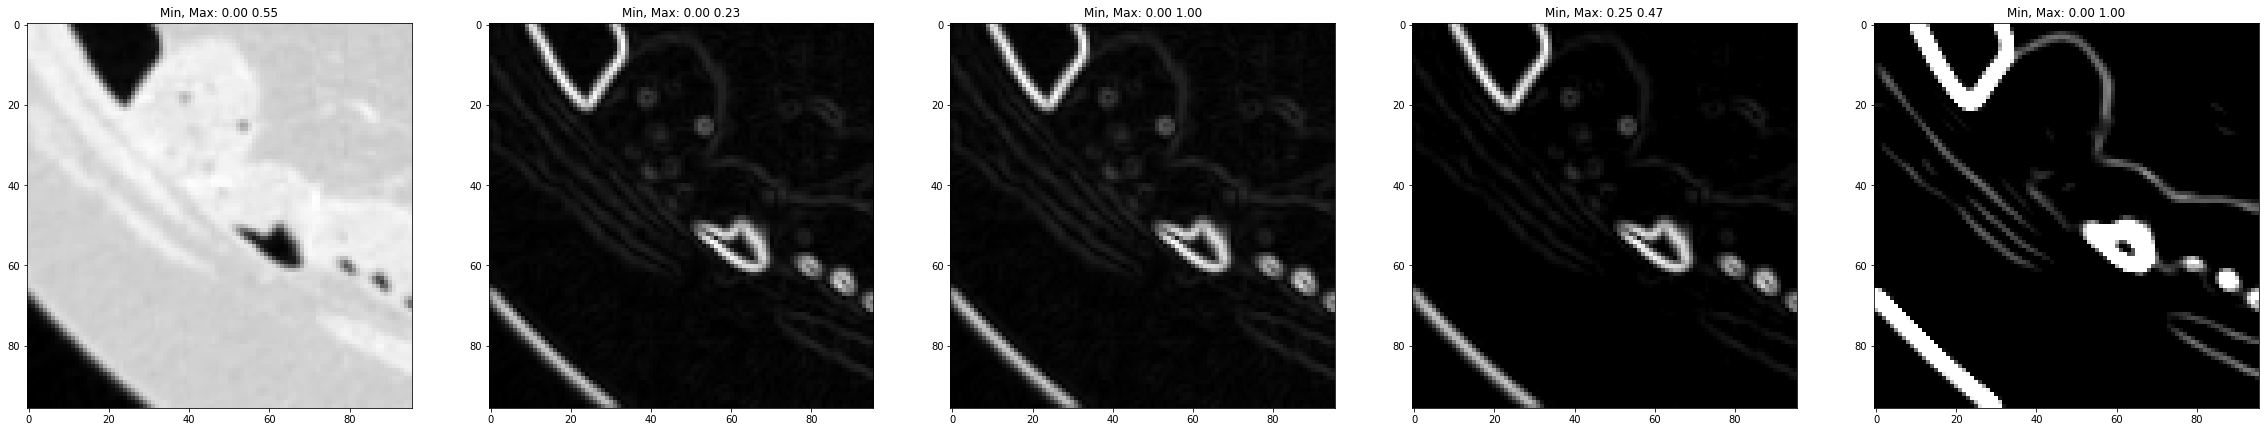

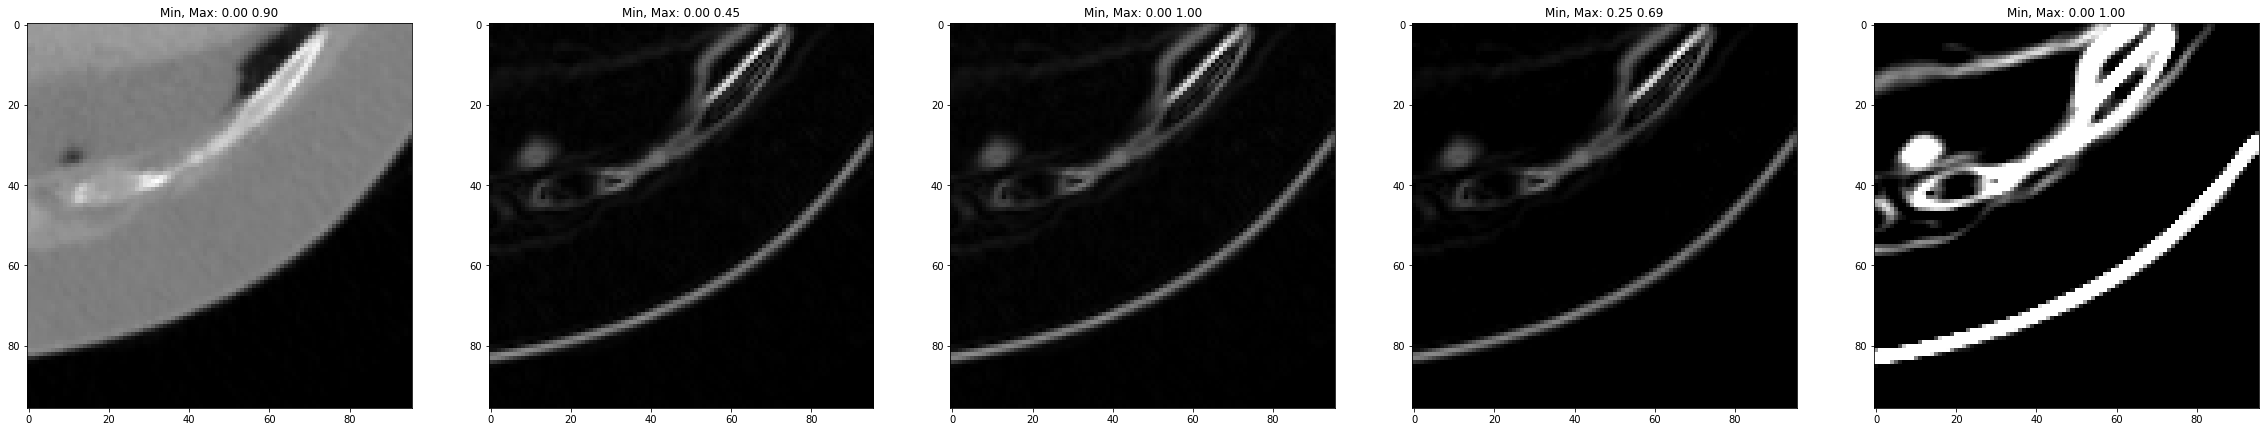

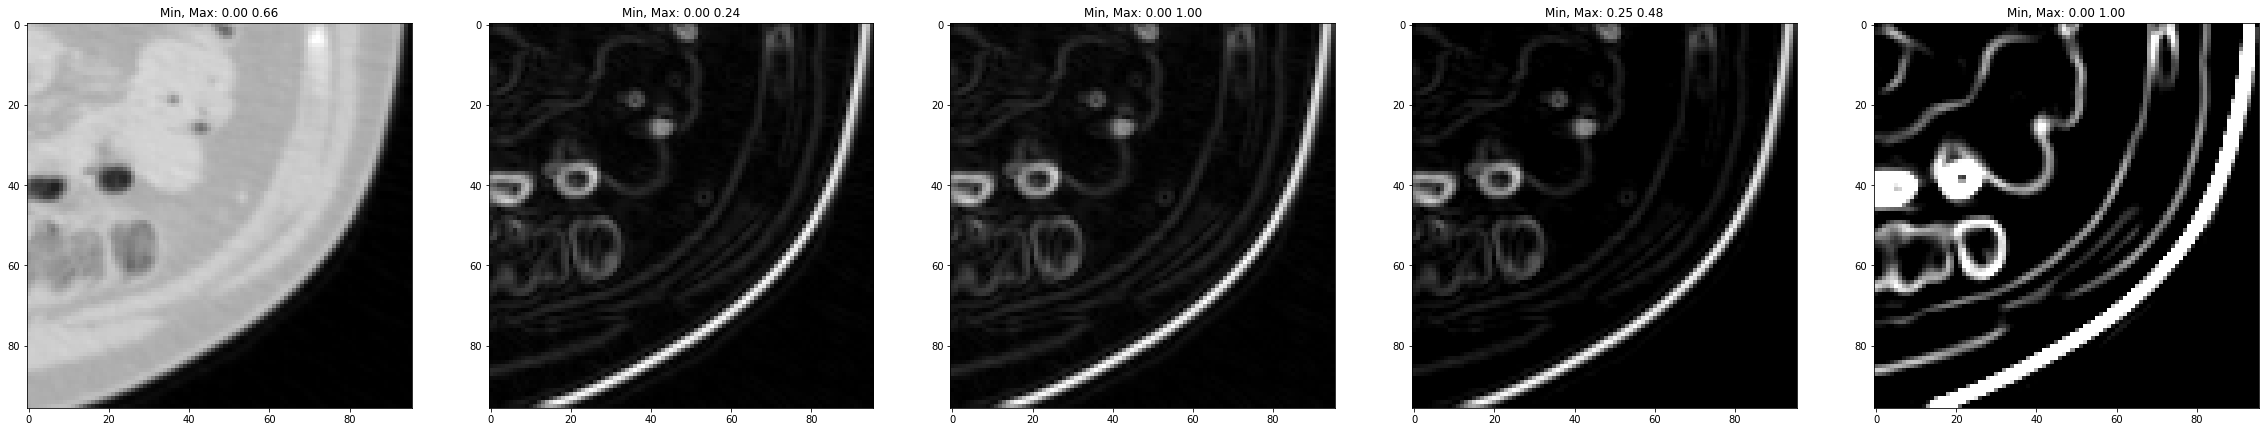

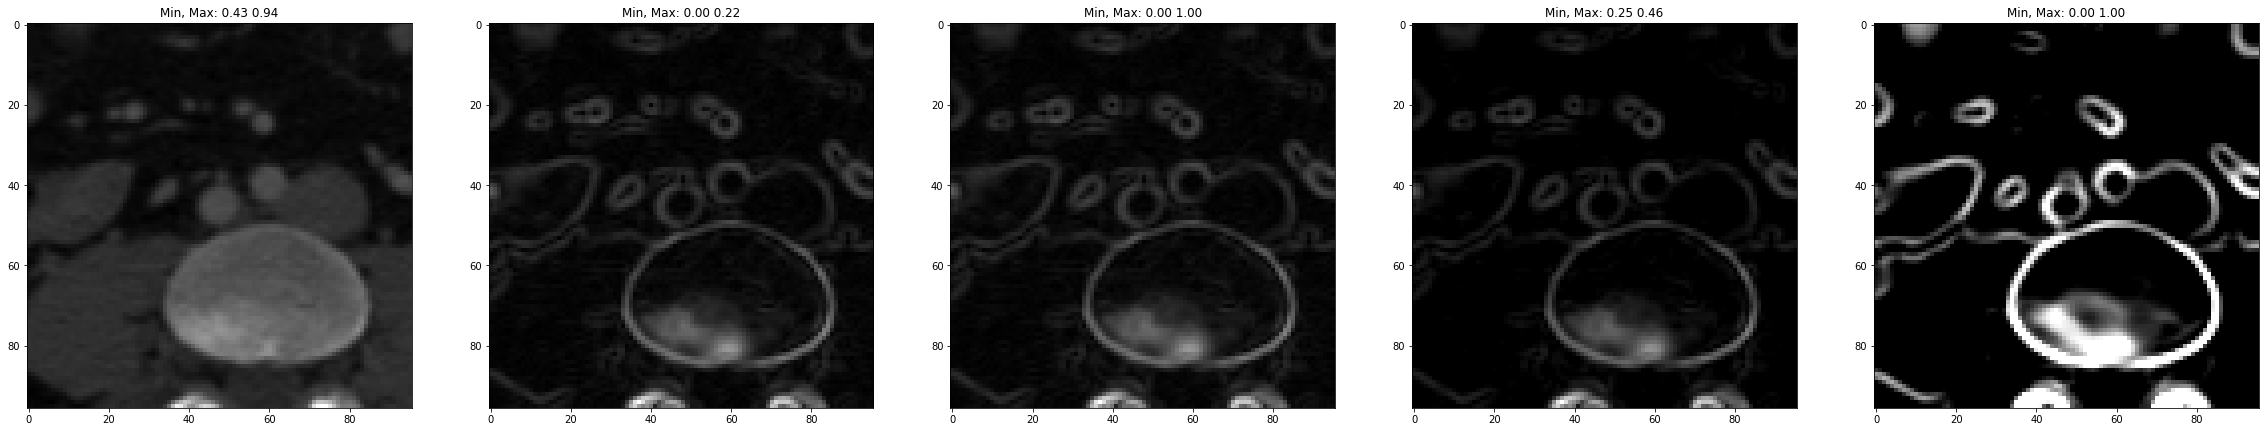

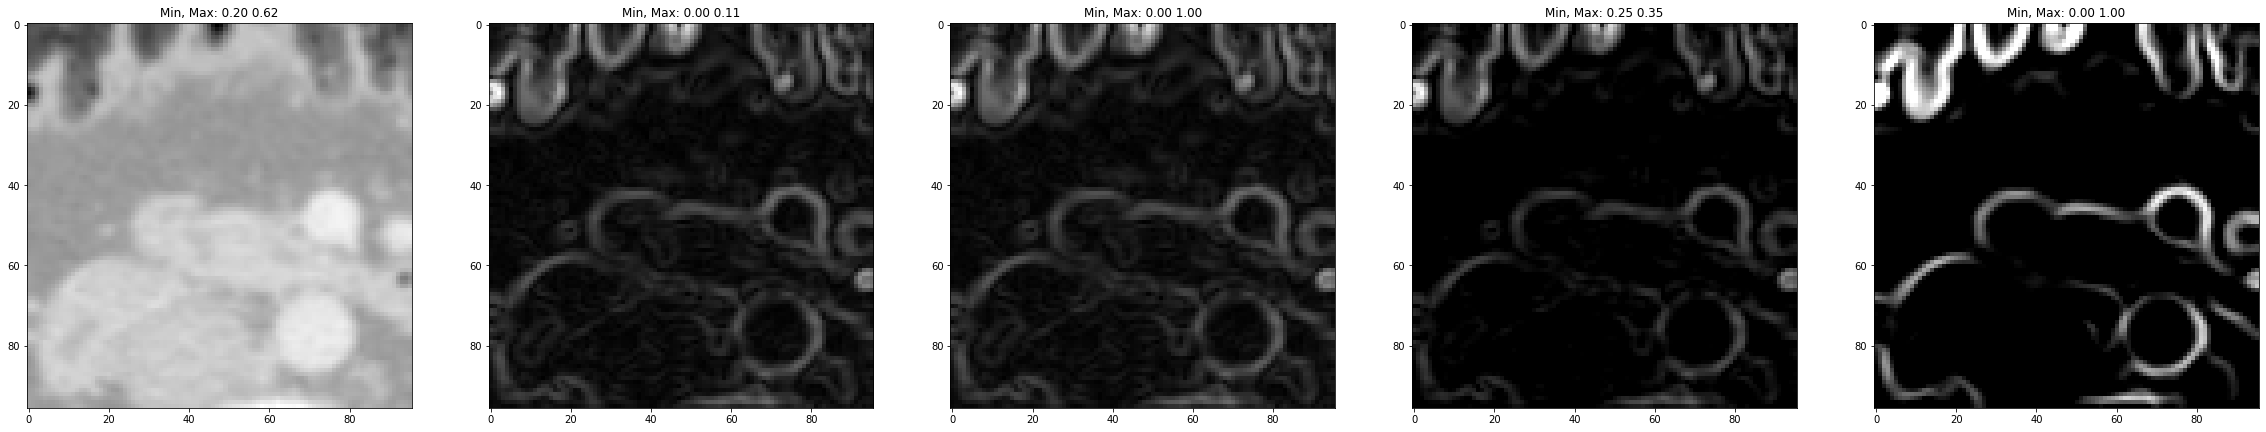

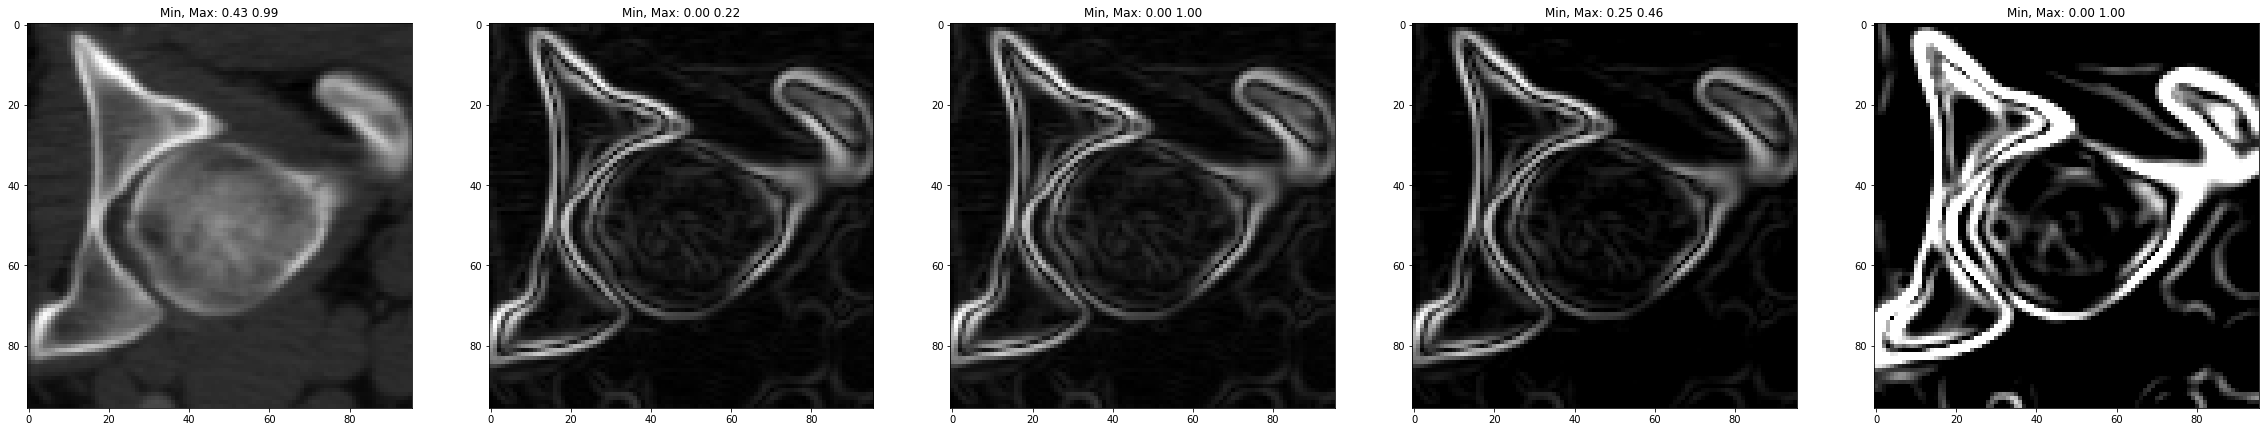

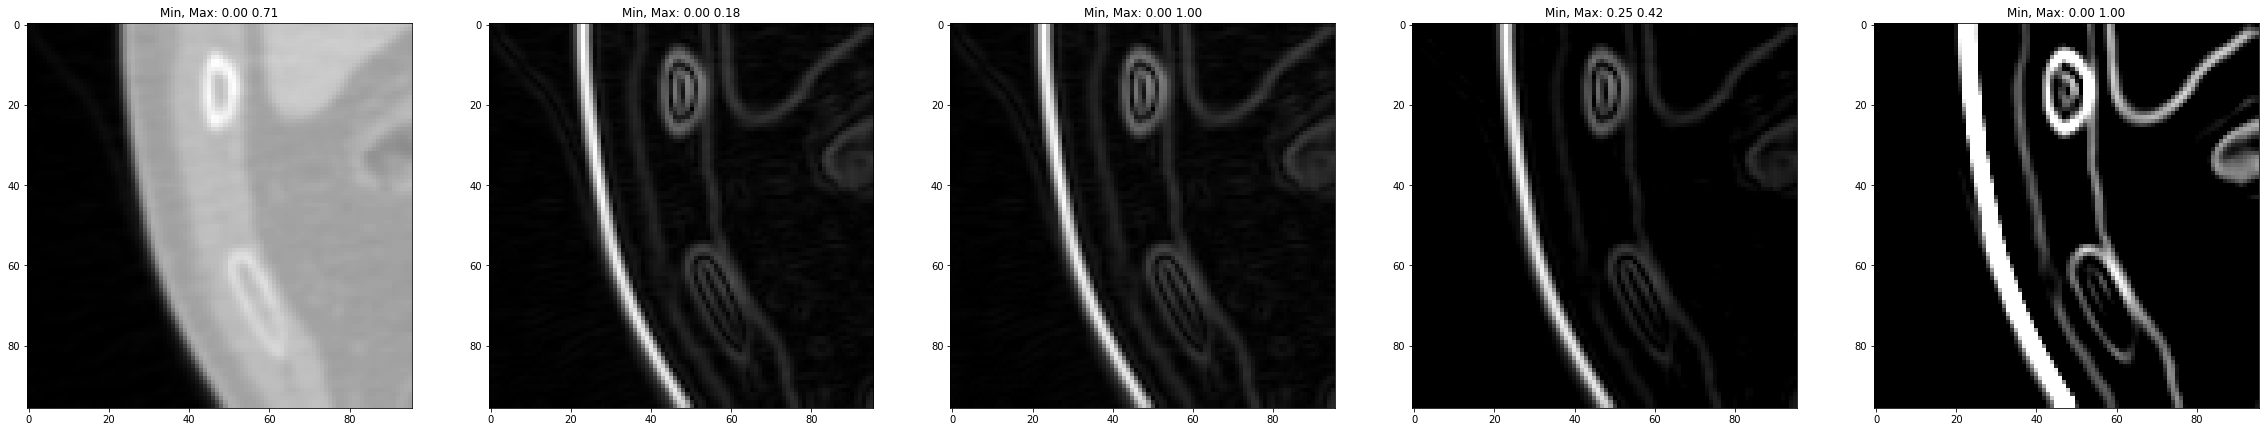

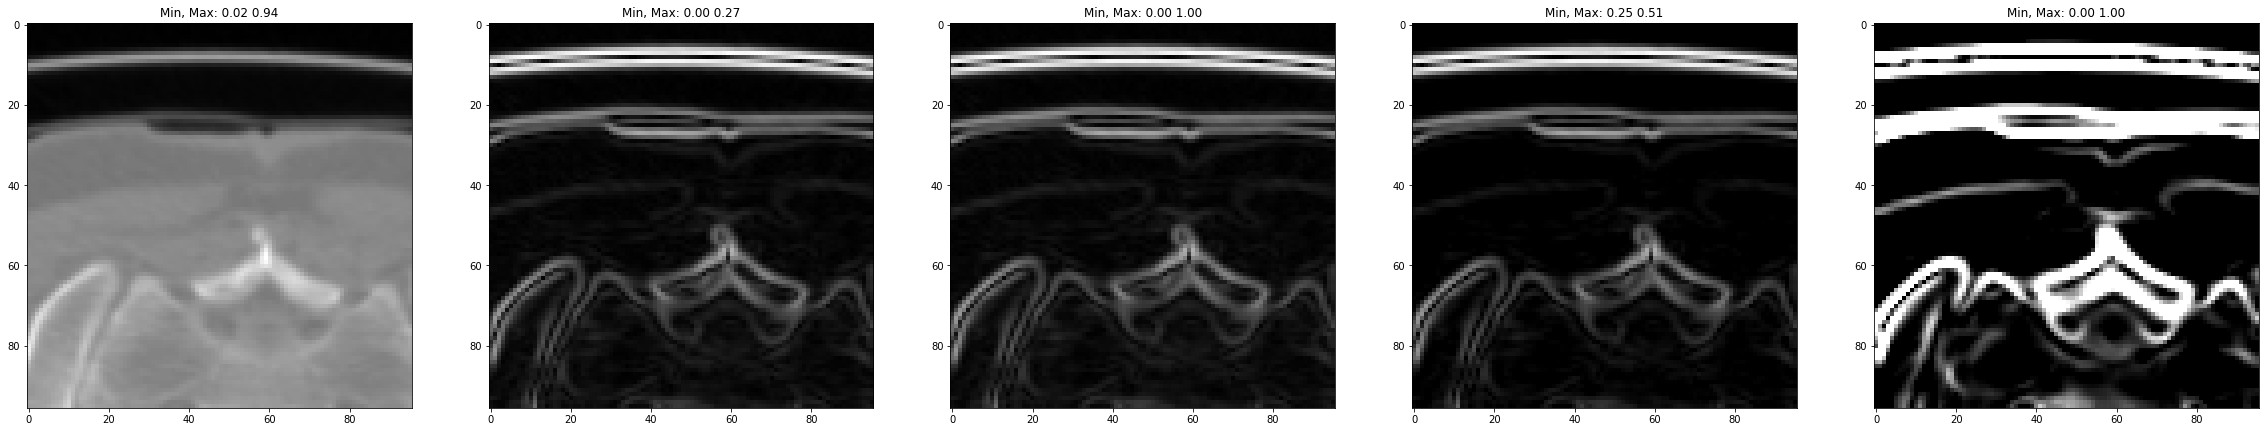

In [101]:
def adjust_contrast(image, per_slice=False):
    if image.ndim == 3 and per_slice:
        new_image = np.zeros_like(image)
        for i in range(image.shape[0]):
            bot, top = image[i].min(), image[i].max()
            new_image[i] = np.clip((image[i] - bot) / (top - bot), 0, 1)
        return new_image
    bot, top = image.min(), image.max()
    image = np.clip((image - bot) / (top - bot), 0, 1)
    return image

for b in range(Y.shape[0]):
    image_arr = Y[b][0].numpy()
    denoised = ndi.median_filter(image_arr, size=5)
    
    # Original Image
#     sobel_edge = filters.sobel(image_arr)
#     plot_image([image_arr, 
#                 adjust_contrast(image_arr[image_arr.shape[0]//2]), 
#                 sobel_edge,
#                 np.clip((sobel_edge - 0.01) * 20, 0, 1)])

    # Edge detection
    schar_edge = filters.scharr(image_arr)
    filt_schar_edge = filters.scharr(denoised)
    
    new_edge = np.zeros_like(schar_edge)
    for i in range(schar_edge.shape[0]):
        t = threshold_otsu(schar_edge[i])
        new_edge[i] = schar_edge[i] > t
    
    plot_image([image_arr, 
                schar_edge, 
                adjust_contrast(schar_edge, per_slice=True),
                np.clip(np.clip((schar_edge - 0.01), 0, 1) + 0.25, 0, 1),
                np.clip((filt_schar_edge - 0.01) * 30, 0, 1)])
    
    # Canny Edge
#     import SimpleITK as sitk
#     canny_filter = sitk.CannyEdgeDetectionImageFilter()
#     canny_filter.SetVariance(10)
#     sim = canny_filter.Execute(sitk.GetImageFromArray(denoised))
#     canny_arr = sitk.GetArrayFromImage(sim)
#     plot_image([image_arr, 
#                 canny_arr,
#                 adjust_contrast(schar_edge, per_slice=True),
#                 np.clip((schar_edge - 0.01) * 20, 0, 1)])
    
    continue
    
    # Denoised
    denoised = ndi.median_filter(image_arr, size=3)
    plot_image([denoised, filters.sobel(denoised)])

    # Scharr Edge


    plot_image(denoised)
    equalized = exposure.equalize_hist(image_arr)
    plot_image(equalized)
    plot_image(filters.sobel(equalized))
    edges = filters.sobel(denoised)
    plot_image(edges)


(0.18212506404027132, 0.0, 0.9788883)